In [3]:
%load_ext autoreload
%autoreload 2

import utilities
from evaluator import Evaluator
from embedder import Embedder
from embedder import Transformer
from embedder import Transformer_GNN
from embedder import Transformer_GNN_embedder
from embedder import Preprocessing_scaler
from Graph_generator import Graph_Generator
import tmp_generator as tmp
from visualizator import Visualizator

from eden import graph
import umap 

import numpy as np
from sklearn.decomposition import TruncatedSVD
import networkx as nx
import sklearn as sk

Using TensorFlow backend.
/home/antonio/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Load dataset generated using CFG

## Dataset generated from: 624249

In [39]:
def load_generated_data_classification(path):
    
    graphs = nx.read_gpickle(path+'/'+'graphs.gpickle')
    labels = list(np.load(path+'/'+'labels.npy'))
    
    return (graphs,labels)

def sub_sample_classification(graphs,labels, n_graphs):
    
    graphs, labels = sk.utils.shuffle(graphs, labels)
        
    return (graphs[0:n_graphs],labels[0:n_graphs])


In [40]:
graphs, labels = load_generated_data_classification("generate_graphs/624249_graphs_cla_09_2000_complex")

In [41]:
graphs, labels = sub_sample_classification(graphs,labels,500)

In [42]:
for g in graphs:
    for node in g.nodes():
        g.nodes[node]['vec'] = []
for g in graphs:
    for edge in g.edges():
        g.edges[edge]['vec'] = []

#graphs = tmp_preprocessing_vectorize(graphs)


In [43]:
# ldp
#functions = [utilities.degree,utilities.clust_coefficient,utilities.local_degree_profile]
#functions = [utilities.degree,utilities.clust_coefficient]
functions = [utilities.degree]

graphs = utilities.add_info_to_nodes(graphs,functions)

max_n_nodes, n_attributes = utilities.find_shapes(graphs)
n_classes = len(np.unique(labels))


print("done")


# setting 
dim = [2]
times = 1


batch_size = 32
validation_split = 0.2
epochs_GNN = 1500
epochs_autoencoder = 10000
verbose=0
plot=False


patience_GNN = 150
patience_autoencoder = 500

done


## Embedder 1
### Spektral + PCA

In [44]:
my_GNN = tmp.generate_GNN(max_n_nodes,
                      n_attributes,
                      n_classes,
                      batch_size = batch_size,
                      validation_split = validation_split,
                      epochs = epochs_GNN,
                      patience = patience_GNN,
                      verbose = verbose, 
                      plot=plot)

m_1 = Transformer(my_GNN)
m_2 = Transformer(TruncatedSVD())
emb_1 = Embedder([m_1,m_2],"Spektral + PCA")

## Embedder 2
### Spektral + Small 128 - n_components

In [45]:
my_GNN_small = tmp.gen_gnn_small(max_n_nodes,
                                 n_attributes,
                                 batch_size = batch_size,
                                 validation_split = validation_split,
                                 epochs = epochs_GNN,
                                 patience = patience_GNN,
                                 dim = dim,
                                 plot = plot)

m_1 = Transformer(my_GNN_small)
emb_2 = Embedder([m_1],"Spektral + small")

## Embedder 3
### Spektral + Dense 128 - 64 - 32 - 16 -  8 - n_components

In [46]:
my_GNN_dense = tmp.gen_gnn_dense(max_n_nodes,
                                 n_attributes,
                                 batch_size = batch_size,
                                 validation_split = validation_split,
                                 epochs = epochs_GNN,
                                 dim = dim,
                                 patience = patience_GNN,
                                 plot = plot)

m_1 = Transformer(my_GNN_dense)
emb_3 = Embedder([m_1],"Spektral + dense")

## Embedder 4
### Spektral fino a 128 + Autoencoder 128 - 64- 16 - 8 - 5 - 3 - 2
### Preprocessing_scaler -0.5 ; 0.5

In [47]:
# modello 1 GNN
my_GNN = tmp.generate_GNN(max_n_nodes,n_attributes,n_classes,
                           batch_size=batch_size,
                           validation_split=validation_split,
                           verbose=verbose,
                           epochs=epochs_GNN,
                           patience= patience_GNN,
                           plot=plot)
m_1 = Transformer(my_GNN)

# preprocessing scaler
my_scaler = Preprocessing_scaler([0, 0.5])
# modello 2 Autoencoder
my_Autoencoder = tmp.gen_transf_autoencoder(batch_size=batch_size,
                                            validation_split=validation_split,
                                            epochs=epochs_autoencoder, 
                                            patience = patience_autoencoder,
                                            verbose=verbose,
                                            scaler=my_scaler,
                                            dim = dim,
                                            plot=plot)

m_2 = Transformer(my_Autoencoder)


emb_4 = Embedder([m_1,m_2], name="Spketral 128 - Autoencoder denso")

## Embedder 5
### Vectorize + pca 1000 + umap

In [48]:
vetcoriz = graph.Vectorizer(complexity = 5)
m_1= Transformer(vetcoriz, has_fit = False)
pca = TruncatedSVD(n_components=1000)
m_2 = Transformer(pca)
uma = umap.UMAP()
m_3 = Transformer(uma)

emb_5 = Embedder([m_1,m_2,m_3], name="Vectorize-5, PCA-1000, UMAP")

In [49]:

emb = [emb_1,emb_2,emb_3,emb_4,emb_5]

vis_500_D = utilities.repeat_n_times(graphs, labels, emb , dim, 1,test_size=0.3,seed = 11)

	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + PCA
1074
	 	 	  Spektral + small
1320
	 	 	  Spektral + dense
0
	 	 	  Spketral 128 - Autoencoder denso
1370
4079
	 	 	  Vectorize-5, PCA-1000, UMAP



			 ****** 500 grafi con:

			 ****** 	 degree

			 ****** 	 clust_coeff

			 ****** 	 Local degree profile
                                      2    STD    mean
--------------------------------  -----  -----  ------
Spektral + PCA                    0.898  0.061   0.48
Spektral + small                  0.926  0.077   0.502
Spektral + dense                  0.9    0.065   0.483
Spketral 128 - Autoencoder denso  0.928  0.06    0.494
Vectorize-5, PCA-1000, UMAP       1      0       0.5
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      5       5
Spektral + small                    3       3
Spektral + dense                    4       4
Spketral 128 - Autoencoder denso    2       2
Vectorize-5, PCA-1000, UMAP         1       1


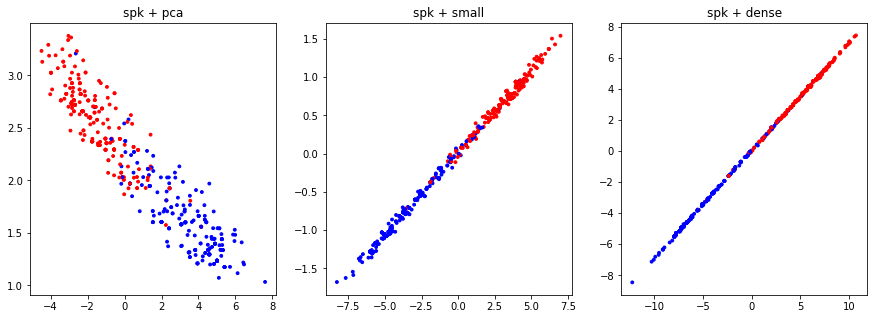

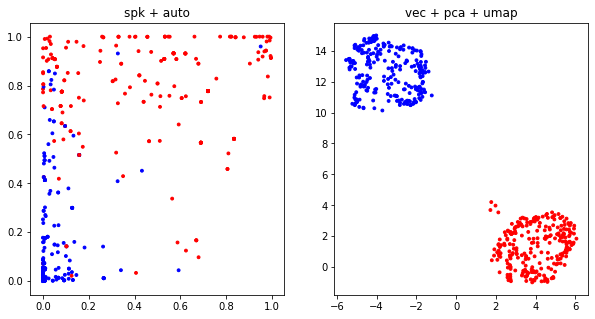

In [25]:
print("\n\t\t\t ****** 500 grafi con:")
print("\n\t\t\t ****** \t degree")
print("\n\t\t\t ****** \t clust_coeff")
print("\n\t\t\t ****** \t Local degree profile")

vis_500_D_clu_LDP.summary()
vis_500_D_clu_LDP.rank()
plot_embedding(emb)


			 ****** 500 grafi con:

			 ****** 	 degree

			 ****** 	 clust_coeff
                                      2    STD    mean
--------------------------------  -----  -----  ------
Spektral + PCA                    0.765  0.12    0.442
Spektral + small                  0.747  0.132   0.44
Spektral + dense                  0.819  0.098   0.458
Spketral 128 - Autoencoder denso  0.709  0.104   0.406
Vectorize-5, PCA-1000, UMAP       1      0       0.5
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      3       3
Spektral + small                    4       4
Spektral + dense                    2       2
Spketral 128 - Autoencoder denso    5       5
Vectorize-5, PCA-1000, UMAP         1       1


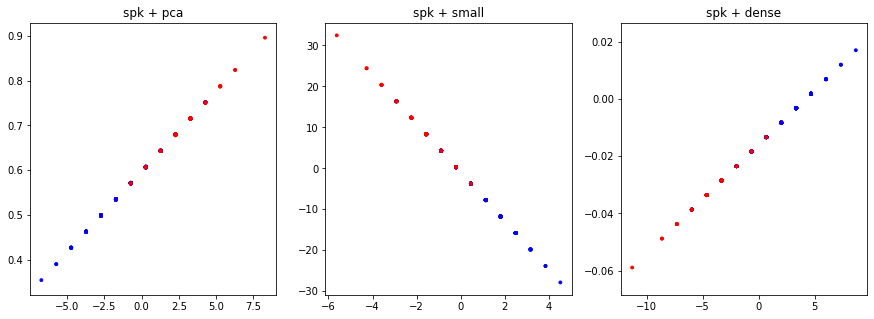

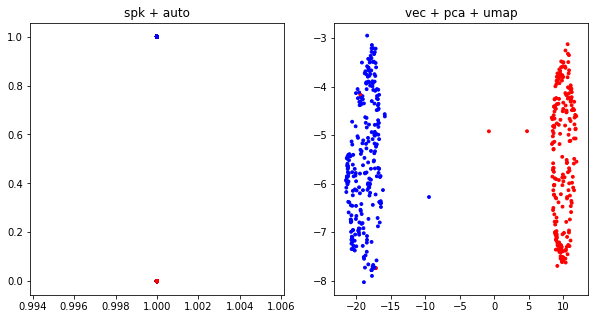

In [38]:
print("\n\t\t\t ****** 500 grafi con:")
print("\n\t\t\t ****** \t degree")
print("\n\t\t\t ****** \t clust_coeff")

vis_500_D_clu.summary()
vis_500_D_clu.rank()
plot_embedding(emb)


			 ****** 500 grafi con:

			 ****** 	 degree
                                      2    STD    mean
--------------------------------  -----  -----  ------
Spektral + PCA                    0.734  0.065   0.399
Spektral + small                  0.766  0.115   0.44
Spektral + dense                  0.778  0.127   0.452
Spketral 128 - Autoencoder denso  0.759  0.11    0.434
Vectorize-5, PCA-1000, UMAP       0.98   0.03    0.505
                                    2    mean
--------------------------------  ---  ------
Spektral + PCA                      5       5
Spektral + small                    3       3
Spektral + dense                    2       2
Spketral 128 - Autoencoder denso    4       4
Vectorize-5, PCA-1000, UMAP         1       1


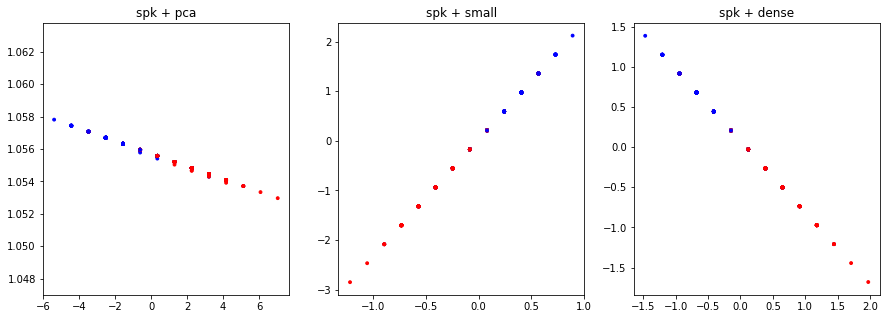

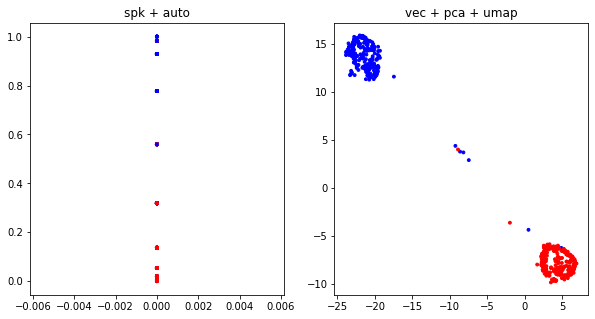

In [50]:
print("\n\t\t\t ****** 500 grafi con:")
print("\n\t\t\t ****** \t degree")

vis_500_D.summary()
vis_500_D.rank()
plot_embedding(emb)

500 = Degree 
 800 = Degree Clust coeff 
 1000 - 1500 = Degree Clust coeff LDP


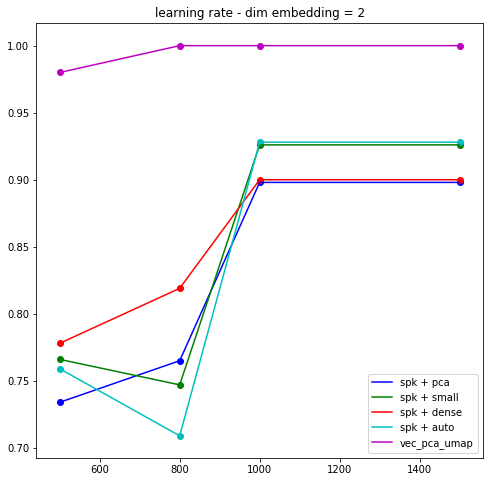

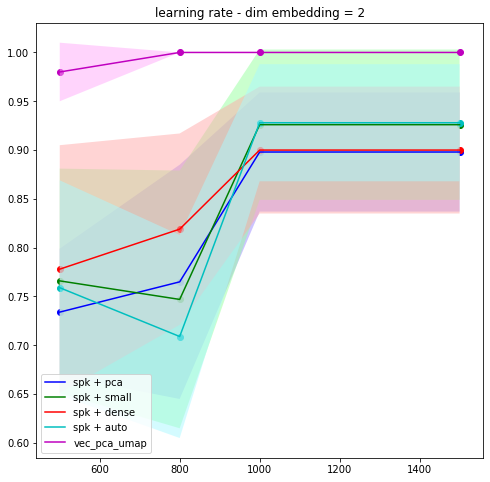

In [52]:
visualizators = [vis_500_D,vis_500_D_clu,vis_500_D_clu_LDP,vis_500_D_clu_LDP]
print("500 = Degree \n 800 = Degree Clust coeff \n 1000 - 1500 = Degree Clust coeff LDP")
tmp_plot(visualizators, 2)
tmp_plot_std(visualizators, 2)

In [20]:
import matplotlib
import matplotlib.pyplot as plt
def plot_embedding(emb):
    colors = ['red','blue']

    plt.figure(figsize=(15,5))
    res = emb[0].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,3,1)
    plt.title("spk + pca")
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))


    res = emb[1].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,3,2)
    plt.title("spk + small")
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))


    res = emb[2].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,3,3)
    plt.title("spk + dense")
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))
    plt.show()


    plt.figure(figsize=(10,5))
    res = emb[3].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,2,1)
    plt.title("spk + auto")
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))


    res = emb[4].transform(graphs[1:500])
    lab = labels[1:500]
    x = res[:,0]
    y = res[:,1]
    plt.subplot(1,2,2)
    plt.title("vec + pca + umap")
    plt.scatter(x,y,s=8,c=lab,cmap=matplotlib.colors.ListedColormap(colors))

    plt.show()



In [22]:
#import dill
#dill.dump_session('models_vs_CFG_graphs_624249.db')

In [23]:
def tmp_preprocessing_vectorize(graphs):        

    for g in graphs:
        
        c=0
        for n in g.nodes():
            a = g.nodes[n]['vec']
            del g.nodes[n]['vec']
            g.nodes[n]['label'] = str(a[0])
            g.nodes[n]['vec'] = a
            c=c+1

    for g in graphs:
        c=0
        for n in g.edges():
            a = g.edges[n]['vec']
            del g.edges[n]['vec']      
            g.edges[n]['label'] = str(a[0])
            g.edges[n]['vec'] = a[0]
            c=c+1

    return(graphs)


import matplotlib.pyplot as plt
def tmp_plot(visualizators,dim_embedding):
    pos = 1
    if (dim_embedding == 2):
        pos = 1
    if (dim_embedding == 3):
        pos = 2
    if (dim_embedding == 5):
        pos = 3

    spk_pca = []
    spk_small = []
    spk_dense = []
    spk_auto = []
    vect_pca_umap = []

    for v in visualizators:
        result_matrix = v.summary(std=False,return_matrix=True)

        spk_pca.append(result_matrix[0][pos])
        spk_small.append(result_matrix[1][pos])
        spk_dense.append(result_matrix[2][pos])
        spk_auto.append(result_matrix[3][pos])
        vect_pca_umap.append(result_matrix[4][pos])

    a = [500,800,1000,1500]
    plt.figure(figsize=(8,8))
    plt.title(str("learning rate - dim embedding = "+str(dim_embedding)))
    plt.plot(a,spk_pca, label='spk + pca',color='b')
    plt.scatter(a,spk_pca,color='b')
    plt.plot(a,spk_small, label='spk + small',color='g')
    plt.scatter(a,spk_small,color='g')
    plt.plot(a,spk_dense, label='spk + dense',color='r')
    plt.scatter(a,spk_dense,color='r')
    plt.plot(a,spk_auto, label='spk + auto',color='c')
    plt.scatter(a,spk_auto,color='c')
    plt.plot(a,vect_pca_umap, label='vec_pca_umap',color='m')
    plt.scatter(a,vect_pca_umap,color='m')
    plt.legend()

In [24]:


def tmp_plot_std(visualizators,dim_embedding):
    if (dim_embedding == 2):
        pos = 1
    if (dim_embedding == 3):
        pos = 3
    if (dim_embedding == 5):
        pos = 5



    spk_pca = []
    spk_pca_std = []
    spk_small = []
    spk_small_std = []
    spk_dense = []
    spk_dense_std = []
    spk_auto = []
    spk_auto_std = []
    vect_pca_umap = []
    vect_pca_umap_std = []

    for v in visualizators:
        result_matrix = v.summary(return_matrix=True)

        spk_pca.append(result_matrix[0][pos])
        spk_pca_std.append(result_matrix[0][pos+1])
        spk_small.append(result_matrix[1][pos])
        spk_small_std.append(result_matrix[1][pos+1])
        spk_dense.append(result_matrix[2][pos])
        spk_dense_std.append(result_matrix[2][pos+1])
        spk_auto.append(result_matrix[3][pos])
        spk_auto_std.append(result_matrix[3][pos+1])
        vect_pca_umap.append(result_matrix[4][pos])
        vect_pca_umap_std.append(result_matrix[4][pos+1])


    a = [500,800,1000,1500]
    plt.figure(figsize=(8,8))
    plt.title(str("learning rate - dim embedding = "+str(dim_embedding)))
    plt.plot(a,spk_pca, label='spk + pca',color='b')
    plt.scatter(a,spk_pca,color='b')
    low = [spk_pca[i]-spk_pca_std[i] for i in range(0,len(spk_pca))]
    upp = [spk_pca[i]+spk_pca_std[i] for i in range(0,len(spk_pca))]
    plt.fill_between(a, low,upp, facecolor='#9B8BFF', alpha=0.5)

    plt.plot(a,spk_small, label='spk + small',color='g')
    plt.scatter(a,spk_small,color='g')
    low = [spk_small[i]-spk_small_std[i] for i in range(0,len(spk_small))]
    upp = [spk_small[i]+spk_small_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#97ff9f', alpha=0.5)

    plt.plot(a,spk_dense, label='spk + dense',color='r')
    plt.scatter(a,spk_dense,color='r')
    low = [spk_dense[i]-spk_dense_std[i] for i in range(0,len(spk_small))]
    upp = [spk_dense[i]+spk_dense_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#ffaaaa', alpha=0.5)

    plt.plot(a,spk_auto, label='spk + auto',color='c')
    plt.scatter(a,spk_auto,color='c')
    low = [spk_auto[i]-spk_auto_std[i] for i in range(0,len(spk_small))]
    upp = [spk_auto[i]+spk_auto_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#aaf9ff', alpha=0.5)
    vect_pca_umap_std

    plt.plot(a,vect_pca_umap, label='vec_pca_umap',color='m')
    plt.scatter(a,vect_pca_umap,color='m')
    low = [vect_pca_umap[i]-vect_pca_umap_std[i] for i in range(0,len(spk_small))]
    upp = [vect_pca_umap[i]+vect_pca_umap_std[i] for i in range(0,len(spk_small))]
    plt.fill_between(a, low,upp, facecolor='#ffaafb', alpha=0.5)


    plt.legend()